In [1]:
import numpy as np
from matplotlib import pyplot as plt
from bruges.filters import ricker, rotate_phase
from scipy import linalg as la
from numpy.linalg import lstsq

from sklearn import linear_model
%matplotlib inline


/Users/Evan/anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [2]:
def norm(data):
    return data/np.amax(data)

In [3]:
def make_synthetic(rpp):
    dt = 0.002
    duration = rpp.size * dt -dt # seconds
    frequency = 60.0 # Hz

    test_wave = np.roll(rotate_phase(ricker(duration, dt, frequency), np.pi/3.0), -rpp.size//2 + 30)
    test_seis = np.convolve(test_wave, rpp, mode='full')[:rpp.size]
    
    return test_wave, test_seis
    

In [4]:
def spectral_division(rpp, seismic):
    
    seis_fft = np.fft.fft(seismic)
    ref_fft = np.fft.fft(rpp)

    wavelet_spec = seis_fft / ref_fft
    wavelet_div = np.fft.ifft(wavelet_spec)
    
    return wavelet_div
    

In [5]:
def wigner(rpp, seismic):
    
    opConvolve = la.toeplitz(rpp)
    wavelet = lstsq(opConvolve, seismic)[0]
    return wavelet     

# Read in the data

In [6]:
r = np.load("rpp.npy")
s = np.load("seismic.npy")

dt = .002
t = np.arange(s.size) * dt

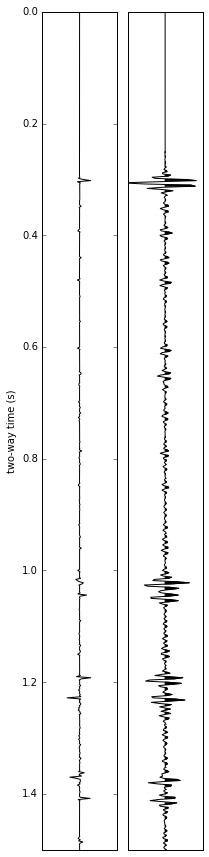

In [8]:
plt.figure(figsize=(3,12))
# Reflectivity track
plt.subplot(121)
plt.plot(r, t, 'k')
plt.xticks([])
plt.xlim(-1,1)
plt.xticks([])
plt.ylim(1.5,0)
plt.ylabel('two-way time (s)')

# Seismic track
plt.subplot(122)
plt.plot(s, t, 'k')
plt.fill_betweenx(t, s, 0,
                  s > 0, color='k', alpha=1.0)
plt.ylim(1.5,0)
plt.xlim(-0.1,0.1)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

In [98]:
Ss = np.abs(np.fft.fft(s))
faxis = np.fft.fftfreq(len(s), d=dt)
Y = np.log10(Ss[0:len(faxis)//2]) 
X = faxis[:len(faxis)//2]

freqs = [5,80,130,160]
c = 1.0
p = c*np.array([-2.5,-0.1,-0.1,-2.5])

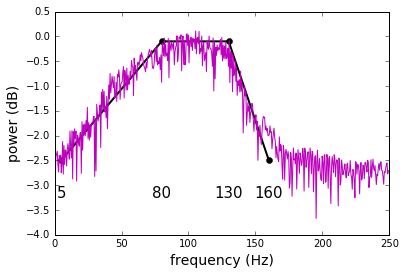

In [99]:
plt.plot(X,Y,'m')
plt.plot(freqs, p, 'ko-', lw=2, zorder=0, ms=6)
for f in freqs:
    plt.text(f,1.20*p[0],f, ha='center', va='top', fontsize=15)
plt.xlabel('frequency (Hz)', fontsize=14)
plt.ylabel('power (dB)', fontsize=14)

### Make an ormsby wavelet using Bruges

In [100]:
from bruges.filters.wavelets import ormsby, ricker

In [114]:
duration = 0.256 # seconds
freq_rick=90
# Ormsby
orms = ormsby(duration, dt=0.002, f=freqs)
tw = np.arange(-len(orms)//2,len(orms)//2,1)*dt

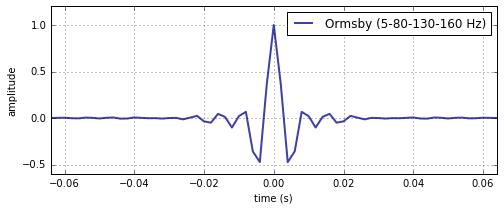

In [118]:
fig =plt.figure(figsize=(8,3))
# plot Ormsby wavelet
plt.plot(tw, orms, 'darkblue', lw=2, alpha=0.75, 
         label='Ormsby (%i-%i-%i-%i Hz)' %(freqs[0],freqs[1],freqs[2],freqs[3]))
plt.legend(loc=1)
plt.xlim(-0.064,0.064)
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.grid()

# Unit test with convolution model and mixed phase.

This would be a cute example to show when autocorrelation and guessing the magnitude spectrum would fail.

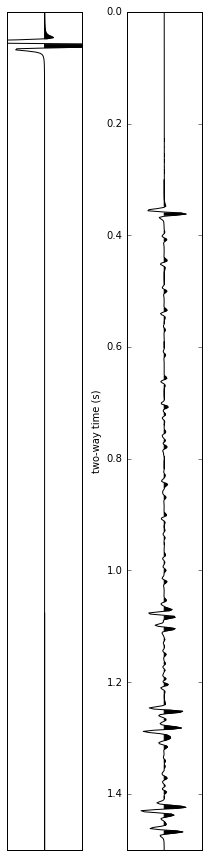

In [9]:
true_wave, synth = make_synthetic(r)
plt.figure(figsize=(3,12))
# Reflectivity track
plt.subplot(122)
plt.plot(synth, t, 'k')
plt.fill_betweenx(t, synth, 0,
                  synth > 0, color='k', alpha=1.0)
plt.xticks([])
plt.xlim(-0.5,0.5)
plt.xticks([])
plt.ylim(1.5,0)
plt.ylabel('two-way time (s)')

# Seismic track
plt.subplot(121)
plt.plot(true_wave, t, 'k')
plt.fill_betweenx(t, true_wave, 0,
                  true_wave > 0, color='k', alpha=1.0)
plt.ylim(1.5,0)
plt.xlim(-0.25,0.25)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

/Users/Evan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 100)

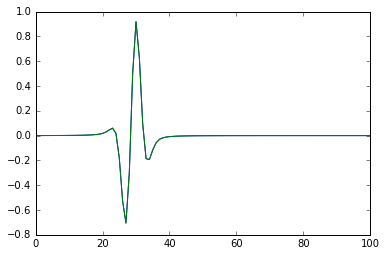

In [10]:
spec_div = spectral_division(r, synth)
plt.figure()
plt.plot(spec_div)
plt.plot(true_wave)
plt.xlim([0,100])

(0, 100)

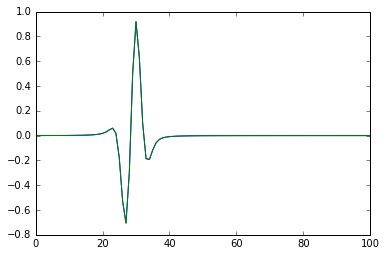

In [11]:
wigner_wave = wigner(r, synth)
plt.plot(wigner_wave)
plt.plot(true_wave)
plt.xlim([0,100])

Both methods recovered the wavelet exactly, which means the code passes the test

# Do it with the modelled and migrated data

True source. Not sure what wavelet changes happened during processing. I imagine the processed wavelet looks quite different.
<img src="true_wave.png">

/Users/Evan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 0.128)

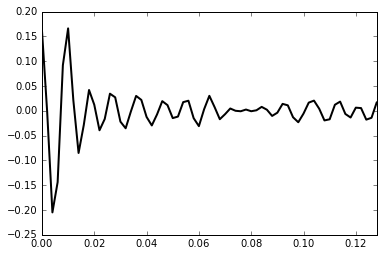

In [70]:
spec_div = spectral_division(r, s)
plt.figure()
plt.plot(t, spec_div, 'k', lw=2)
plt.xlim([0,0.128])

(-1, 1)

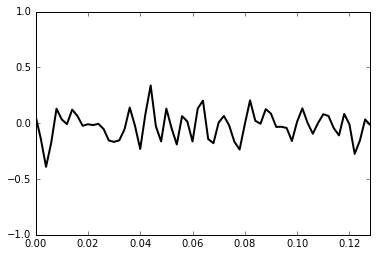

In [147]:
wigner_wave = wigner(r, s)
plt.plot(t, wigner_wave, 'k', lw=2)
plt.xlim([0,0.128])
plt.ylim([-1,1])

Both methods give more or less gibberish, which basically shows that migrated seismic does not adhere to a convolutional model. Let's check the Spectra.

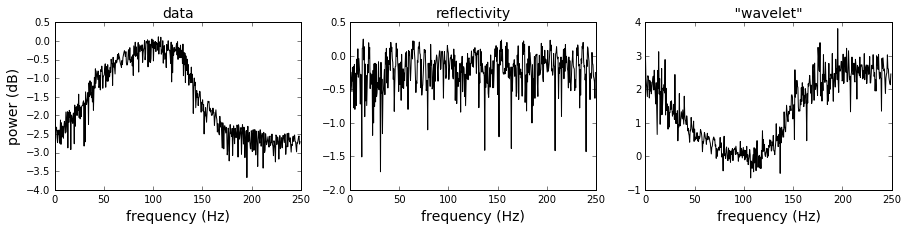

In [154]:
Y1 = np.log10(np.abs(np.fft.fft(s))[0:len(faxis)//2]) 
R1 = np.log10(np.abs(np.fft.fft(r))[0:len(faxis)//2]) 
W1 = np.log10(np.abs(np.abs(np.fft.fft(r) / np.fft.fft(s)))[0:len(faxis)//2]) 

fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(131)

ax.plot(X,Y1, 'k', lw=1)
ax.set_title('data', fontsize=14)
ax.set_ylabel('power (dB)', fontsize=14)
ax.set_xlabel('frequency (Hz)', fontsize=14)

ax2 = fig.add_subplot(132)
ax2.plot(X,R1, 'k', lw=1)
ax2.set_title('reflectivity', fontsize=14)
ax2.set_xlabel('frequency (Hz)', fontsize=14)

ax3 = fig.add_subplot(133)
ax3.plot(X,W1, 'k', lw=1)
ax3.set_title(' "wavelet" ', fontsize=14)
ax3.set_xlabel('frequency (Hz)', fontsize=14)


Gross. Tons of variance and a spectrum that looks nothing like a wavelet. Basically we can't fit the data because a convolutional model sucks at modelling migrated seismic. Let's use some optimization tricks. Regularize the least squares problem and bias it towards an answer we want. Start with something simple, like an L2 norm. Basically we know a priori that we don't want ton of large spikes in our wavelet and an L2 norm will penalize these. Note ridge regression is just least-squares with an L2 penalty.

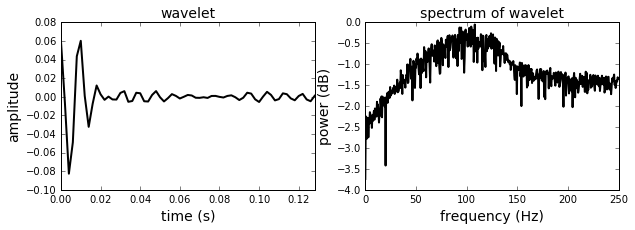

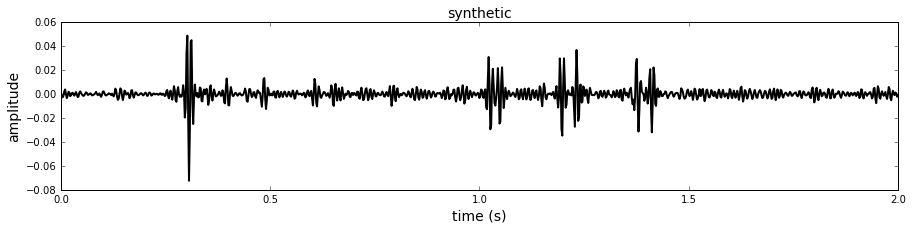

In [170]:
clf = linear_model.Ridge(alpha = 0.5, fit_intercept=False)
C = la.toeplitz(r)
clf.fit(C, s)
wavelet = clf.coef_

Y2 = np.log10(np.abs(np.fft.fft(wavelet))[0:len(faxis)//2])  

fig = plt.figure(figsize = (10,3))
ax = fig.add_subplot(121)
ax.plot(t, wavelet, 'k', lw=2)
ax.set_xlim([0,0.128])
ax.set_title('wavelet', fontsize=14)
ax.set_ylabel('amplitude', fontsize=14)
ax.set_xlabel('time (s)', fontsize=14)

# Check the spectra
ax2 = fig.add_subplot(122)
ax2.plot(X,Y2, 'k', lw=2)
ax2.set_title('spectrum of wavelet', fontsize=14)
ax2.set_ylabel('power (dB)', fontsize=14)
ax2.set_xlabel('frequency (Hz)', fontsize=14)

# modelled seismic
plt.figure(figsize=(15,3))
plt.plot(t, np.dot(C, wavelet), 'k', lw=2)
plt.title('synthetic', fontsize=14)
plt.ylabel('amplitude', fontsize=14)
plt.xlabel('time (s)', fontsize=14)

Hey, not bad. Looks more like wavelet! The spectra has way less variance, but doing the regularization added some noise to our data. Such is life, when our model is wrong we always trade off between fitting the data and seeing what we want to see. 

Let's try some other tricks. We know the approximate length of the wavelet, and it definitely won't be two seconds long. Let's add a projection operator into the mix which forces all the wavelet energy to be in the first few samples.

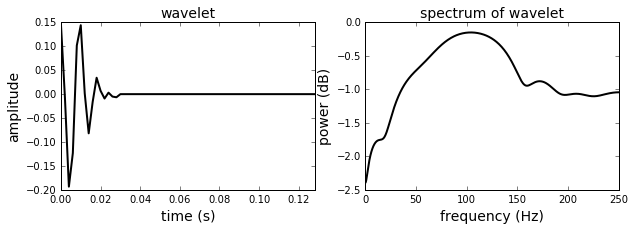

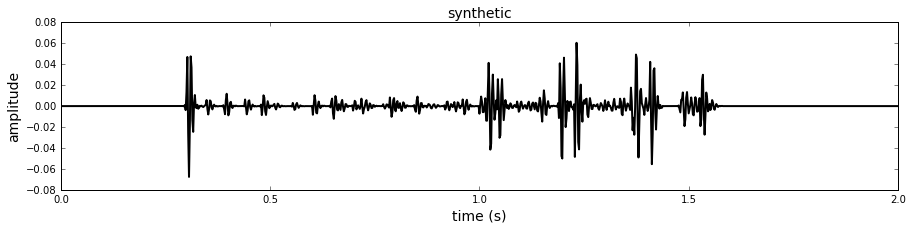

In [171]:
wavelet_size = 15 # samples
opProj = np.zeros((r.size, r.size))
opProj[:wavelet_size, :wavelet_size] = np.eye(wavelet_size)

op  = np.dot(C, opProj)
wavelet = lstsq(op, s)[0]

Y3 = np.log10(np.abs(np.fft.fft(wavelet))[0:len(faxis)//2])  

fig = plt.figure(figsize = (10,3))
ax = fig.add_subplot(121)
ax.plot(t, wavelet, 'k', lw=2)
ax.set_xlim([0,0.128])
ax.set_title('wavelet', fontsize=14)
ax.set_ylabel('amplitude', fontsize=14)
ax.set_xlabel('time (s)', fontsize=14)

# Check the spectra
ax2 = fig.add_subplot(122)
ax2.plot(X,Y3, 'k', lw=2)
ax2.set_title('spectrum of wavelet', fontsize=14)
ax2.set_ylabel('power (dB)', fontsize=14)
ax2.set_xlabel('frequency (Hz)', fontsize=14)

# modelled seismic
plt.figure(figsize=(15,3))
plt.plot(t, np.dot(C, wavelet), 'k', lw=2)
plt.title('synthetic', fontsize=14)
plt.ylabel('amplitude', fontsize=14)
plt.xlabel('time (s)', fontsize=14)

Sweet spectra, but it came at the cost of adding a large reflection at the end of the data. Anyways, there are a billion different ways to re-formulate the least-squares problem. It's actually at bit addictive. 

Take home: 
The basic convolution model can't fit the data. There are multiples, processing issues, and migrations effects that aren't accounted. Because the model is wrong we are going to get a wrong answer, so we use regularization and other optimization tricks so we at least get a wrong answer that looks legit. 

Something else to think about: 
This is synthetic data, and things are already messy and uncertain for even the simplest inversion. Things are obviously going to be total non-sense on real data. More complicated inversions like Shuey-terms, FWI, least-squares RTM... get real ;).

In [178]:
synth = np.dot(op, wavelet)

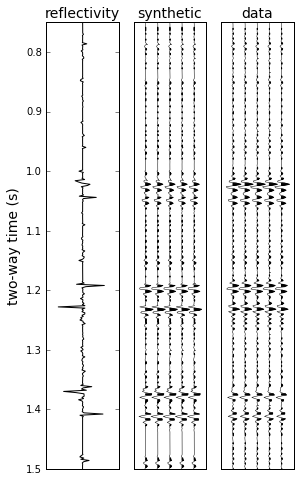

In [184]:
# Params
ylim = (0.75, 1.5)
# N wiggles
nwigs = 5
gap = 0.1

fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)

# Reflectivity track
ax1.plot(r, t, 'k')
ax1.set_xticks([])
ax1.set_xlim(-0.5,0.5)
ax1.set_xticks([])
ax1.set_xlabel('reflectivity', fontsize=14)
ax1.xaxis.set_label_position('top') 
ax1.set_ylim(ylim[1],ylim[0])
ax1.set_ylabel('two-way time (s)', fontsize=14)

# Synthetic track
for i in range(nwigs):
    ax2.plot(synth+i*gap, t, 'k', lw=0.5)
    ax2.fill_betweenx(t, synth+i*gap, i*gap,
                      synth+i*gap > i*gap, color='k', alpha=1.0)
ax2.set_xlim(-gap,gap*(nwigs))
ax2.set_ylim(ylim[1],ylim[0])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('synthetic', fontsize=14)
ax2.xaxis.set_label_position('top') 


# Seismic track
for i in range(nwigs):
    ax3.plot(s+i*gap, t, 'k', lw=0.5)
    ax3.fill_betweenx(t, s+i*gap, i*gap,
                      s+i*gap > i*gap, color='k', alpha=1.0)
ax3.set_xlim(-gap,gap*(nwigs))
ax3.set_ylim(ylim[1],ylim[0])
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlabel('data', fontsize=14)
ax3.xaxis.set_label_position('top') 

# Wavelet track
if False:
    ax4 = fig.add_subplot(144)
    ax4.plot(wavelet, t, 'k', lw=0.5)
    ax4.fill_betweenx(t, wavelet, 0,
                      wavelet > 0, color='k', alpha=1.0)
    ax4.set_ylim(ylim[1],ylim[0])
    ax4.set_xlim(-0.1,0.1)
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.tight_layout()

Finally, we can compute the correlation coefficient between the synthetic and the data.

In [176]:
np.corrcoef(s,synth)[0][1]

0.72822889666191759

We can plot the autocorrelation of the wavelet to show its zero phase version to compare with the other zero phase wavelets

/Users/Evan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


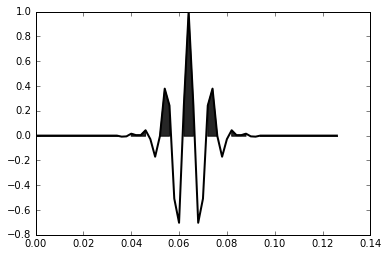

In [53]:
wzeroph = norm(np.correlate(norm(wavelet), norm(wavelet), mode='same'))
dw = 64
wshort = wzeroph[len(wzeroph)//2-dw/2:len(wzeroph)//2+dw/2]
tshort = np.arange(0,len(wshort),1)*dt
plt.plot(tshort, wshort,'k', lw=2)
plt.fill_between(tshort, wshort, -0.005,
                      wshort > -0.005, color='k', alpha=0.85)

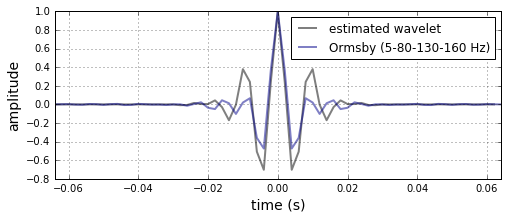

In [127]:
fig =plt.figure(figsize=(8,3))
# plot Ormsby wavelet

plt.plot(tshort-0.064, wshort,'k', lw=2, alpha=0.5, label='estimated wavelet')

plt.plot(tw, orms, 'darkblue', lw=2, alpha=0.5, 
         label='Ormsby (%i-%i-%i-%i Hz)' %(freqs[0],freqs[1],freqs[2],freqs[3]))
plt.legend(loc=1)
plt.xlim(-0.064,0.064)
plt.xlabel('time (s)', fontsize=14)
plt.ylabel('amplitude', fontsize=14)
plt.grid()

In [187]:
synth = np.convolve(norm(wzeroph),r,mode='same')

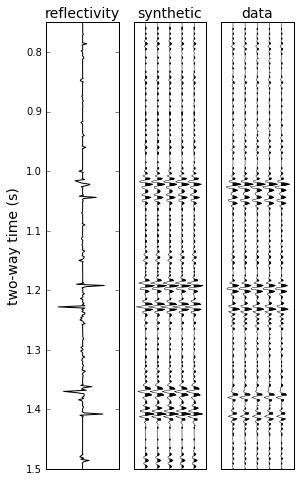

In [189]:
# Params
ylim = (0.75, 1.5)
# N wiggles
nwigs = 5
gap = 0.1
g = 0.25  # gain

fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)

# Reflectivity track
ax1.plot(r, t, 'k')
ax1.set_xticks([])
ax1.set_xlim(-0.5,0.5)
ax1.set_xticks([])
ax1.set_xlabel('reflectivity', fontsize=14)
ax1.xaxis.set_label_position('top') 
ax1.set_ylim(ylim[1],ylim[0])
ax1.set_ylabel('two-way time (s)', fontsize=14)

# Synthetic track
for i in range(nwigs):
    ax2.plot(g*synth+i*gap, t, 'k', lw=0.5)
    ax2.fill_betweenx(t, g*synth+i*gap, i*gap,
                      g*synth+i*gap > i*gap, color='k', alpha=1.0)
ax2.set_xlim(-gap,gap*(nwigs))
ax2.set_ylim(ylim[1],ylim[0])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('synthetic', fontsize=14)
ax2.xaxis.set_label_position('top') 


# Seismic track
for i in range(nwigs):
    ax3.plot(s+i*gap, t, 'k', lw=0.5)
    ax3.fill_betweenx(t, s+i*gap, i*gap,
                      s+i*gap > i*gap, color='k', alpha=1.0)
ax3.set_xlim(-gap,gap*(nwigs))
ax3.set_ylim(ylim[1],ylim[0])
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlabel('data', fontsize=14)
ax3.xaxis.set_label_position('top') 

# Wavelet track
if False:
    ax4 = fig.add_subplot(144)
    ax4.plot(wavelet, t, 'k', lw=0.5)
    ax4.fill_betweenx(t, wavelet, 0,
                      wavelet > 0, color='k', alpha=1.0)
    ax4.set_ylim(ylim[1],ylim[0])
    ax4.set_xlim(-0.1,0.1)
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.tight_layout()

In [186]:
np.corrcoef(s,synth)[0][1]

0.81788648323700142